# Spline cubique

&nbsp;

<center>**Loic Gouarin**</center>
<center>11 juillet 2017</center>

&nbsp;

Nous nous intéresserons ici à l'implémentation des splines cubiques avec NumPy. Le choix de cette exercice vient du site [inconvergent](http://inconvergent.net/generative). En prenant une figure géométrique de départ et en y associant une spline cubique passant par un ensemble de points discrétisant celle-ci, il est possible par petites perturbations successives d'avoir de très jolies images.

## Définition d'une spline cubique

Nous considérons une spline cubique qui passe par les points $(x_i,y_i)$ avec $a=x_1<\ldots<x_n=b$, c'est-à-dire une fonction de classe ${\mathcal C}^2$ sur $[a,b]$ et dont chaque restriction à l'intervalle $[x_{i-1},x_i]$, $1\leq i\leq n$, est un polynôme de degré inférieur à 3. Nous noterons $S$ une telle spline. Son équation est donnée par

$$
 S_i(x) =  Ay_i + By_{i+1} + Cy''_i+ D y''_{i+1}, \qquad x_{i}\leq x\leq x_{i+1},
$$

où

$$
A = \frac{x_{i+1}-x}{x_{i+1} - x_i} \qquad \text{et} \qquad B = \frac{x-x_i}{x_{i+1} - x_i},
$$

$$
C = \frac{1}{6}\left(A^3-A\right)\left(x_{i+1}-x_i\right)^2 \qquad \text{et} \qquad D = \frac{1}{6}\left(B^3-B\right)\left(x_{i+1}-x_i\right)^2.
$$

Si nous dérivons deux fois cette équation par rapport à $x$, nous obtenons

$$
\frac{d^2S(x)}{d x} = Ay''_i + By''_{i+1}.
$$

Etant donné que $A=1$ en $x_i$ et $A=0$ en $x_{i+1}$ et inversement pour $B$, nous pouvons constater que la dérivée seconde est bien continue au bords entre les deux intervalles $[x_{i-1}, x_{i}]$ et $[x_{i}, x_{i+1}]$.

Il nous reste à déterminer l'expression de $y''_i$. Pour ce faire, nous allons calculer la dérivée première et imposer qu'elle soit continue au bord de deux intervalles. La dérivée première est donnée par

$$
\frac{dy}{dx}=\frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}}-\frac{3A^2-1}{6}(x_{i+1}-x_{i})y''_i+\frac{3B^2-1}{6}(x_{i+1}-x_{i})y''_{i+1}.
$$

Nous souhaitons donc que la valeur de la dérivée première en $x=x_i$ sur l'intervalle $[x_{i-1}, x_{i}]$ soit égale à la valeur de la dérivée première en $x=x_i$ sur l'intervalle $[x_{i}, x_{i+1}]$; ce qui nous donne pour $i=2,\dots,n-1$

$$
a_iy''_{i-1}+b_iy''_i+c_iy''_{i+1}=d_i,
$$

avec 

$$
\begin{array}{l}
a_i = \frac{x_i-x_{i-1}}{x_{i+1}-x_{i-1}}\\
b_i = 2\\
c_i = \frac{x_{i+1}-x_{i}}{x_{i+1}-x_{i-1}}\\
d_i = \frac{6}{x_{i+1}-x_{i-1}}\left(\frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}}-\frac{y_{i}-y_{i-1}}{x_{i}-x_{i-1}}\right).
\end{array}
$$

Nous avons donc $n-2$ équations linéraires pour calculer les $n$ inconnues $y''_i$ pour $i=1,\dots,n$. Nous devons donc faire une choix pour la première et la dernière valeurs et nous les prendrons égales à zéro. Nous pouvons reconnaître la résolution d'un système comportant une matrice tridiagonale. Il est alors facile de la résoudre en utilisant l'algorithme de Thomas dont on rappelle le principe

$$
c'_i=\left\{ 
\begin{array}{lr}
\frac{ci}{b_i}&i=1\\
\frac{c_i}{b_i-a_ic'_{i-1}}&i=2,\dots,n.
\end{array}
\right.
$$

$$
d'_i=\left\{ 
\begin{array}{lr}
\frac{di}{b_i}&i=1\\
\frac{d_i-a_id'_{i-1}}{b_i-a_ic'_{i-1}}&i=2,\dots,n.
\end{array}
\right.
$$

La solution est alors obtenue par la formule

$$
\begin{array}{l}
y''_n = d'_n \\
y''_i = d'_i-c'_iy''_{i+1} \qquad \text{pour} \qquad i=n-1,\dots,1.
\end{array}
$$

#### La fonction **spline**

La fonction **spline** permet de calculer la dérivée seconde en ayant les points $x_i$ et $y_i$.

In [1]:
import numpy as np

In [2]:
def spline(x, y):
    """
    fonction retournant les valeurs tabulées de la dérivée seconde 
    d'une spline cubique passant par les points (x, y)

    Paramètres
    ----------
    
    x: un tableau NumPy de dimension n
    y: un tableau NumPy de dimension (n, 2)
    
    Sortie
    ------
    
    la dérivée seconde de taille (n, 2)
    """
    n = x.shape[0]
    u = np.zeros_like(y)
    y2 = np.zeros_like(y)

    dif = np.diff(x)
    sig = dif[:-1]/(x[2:]-x[:-2])

    u[1:-1, :] = (y[2:,:]- y[1:-1,:])/dif[1:, np.newaxis] - (y[1:-1,:]-y[:-2,:])/dif[:-1, np.newaxis]

    for i in range(1, n-1):
        p = sig[i-1]*y2[i-1,:] + 2.
        y2[i, :] = (sig[i-1]-1)/p
        u[i, :] = (6*u[i,:]/(x[i+1]-x[i-1])-sig[i-1]*u[i-1,:])/p
    
    for i in range(n-2, -1, -1):
        y2[i,:] = y2[i,:]*y2[i+1,:]+u[i,:]

    return y2

#### La fonction **splint**

Maintenant que nous avons l'équation de notre spline cubique, nous allons pouvoir calculer les valeurs $y_s$ d'un ensemble de points quelconques $x_s$. Pour ce faire, nous rappelons l'équation de la spline cubique

$$
 S_i(x) =  Ay_i + By_{i+1} + Cy''_i+ D y''_{i+1}, \qquad x_{i}\leq x\leq x_{i+1},
$$

où $A$, $B$, $C$ et $D$ sont donnés plus haut. Il est donc nécessaire, pour calculer $y^k_s$ de trouver l'intervalle $[x_{i},x_{i+1}]$ où se trouve $x^k_s$ dans les valeurs tabulées puis d'appliquer $S_i(x^k_s)=y^k_s$.

In [3]:
def splint(xa, ya, y2a, x, y):
    """
    Interpole les points x sur la spline cubique définie par (xa, ya, ya'')
    
    Paramètres
    ----------
    
    xa : tableau NumPy de taille n
    ya : tableau NumPy de taille (n, 2)
    y2a : tableau NumPy de taille (n, 2)
    x : tableau NumPy de taille m
    y: résultats des valeurs de la spline cubique interpollée en x (taille (m, 2))
    
    """
    khi = np.searchsorted(xa, x)
    klo = khi-1
    h = xa[khi] - xa[klo]
    a = ((xa[khi]-x)/h)[:, np.newaxis]
    b = ((x-xa[klo])/h)[:, np.newaxis]
    h = h[:, np.newaxis]
    y[:] = a*ya[klo]+b*ya[khi]+((a**3-a)*y2a[klo]+(b**3-b)*y2a[khi])*h**2/6.

#### Application

In [4]:
def draw_pixel(img, xs, ys, guide, scale=.0005, color=[0.0, 0.41568627450980394, 0.61960784313725492, 1.]):
    """
    ajoute des couches de couleur dans img sur les pixels passant en xs+guide[0] et ys+guide[0].
    """
    size = img.shape[0]
    newxs = np.floor((guide[0] + xs)*size)
    xs_mask = np.logical_and(newxs>=0, newxs<size)
    newys = np.floor((guide[1] + ys)*size)
    ys_mask = np.logical_and(newys>=0, newys<size)
    mask = np.logical_and(xs_mask, ys_mask)
    coords = np.asarray([newxs[mask],newys[mask]], dtype='i8')
    c = np.asarray(color)*scale
    pixels = img[coords[0, :], coords[1, :], :]
    invA = 1. - c[3]
    img[coords[0, :], coords[1, :], :] = c + pixels*invA

def update_path(path, periodic=False, scale_value=0.00001):
    """
    Met à jour le chemin des points définissants la spline cubique.
    """
    n = path.shape[0]
    scale = np.arange(n)*scale_value
    r = 1.0-2.0*np.random.random(n)
    noise = r*scale
    phi = np.random.random(n)*2*np.pi
    rnd = np.c_[np.cos(phi), np.sin(phi)]
    path += rnd*noise[:, np.newaxis]
    if periodic:
        path[-1] = path[0]

In [5]:
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


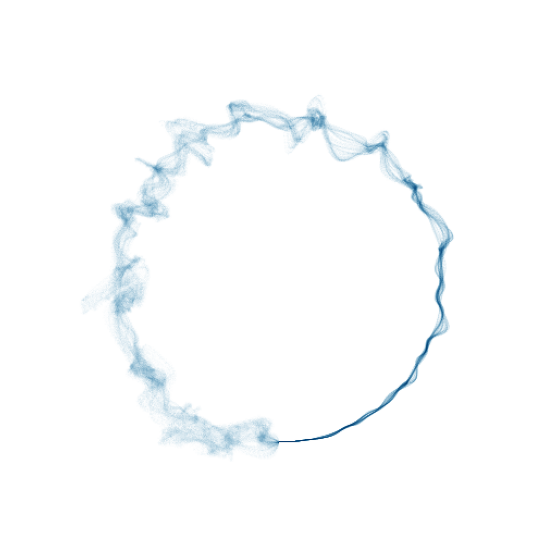

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

output_dir = './output/'

img_size = 500
channels = 4
img = np.ones((img_size, img_size, channels), dtype=np.float32)

nspline = 75
theta = 2 * np.pi * np.linspace(0, 1, nspline)
r = 0.3
path = np.c_[r*np.cos(theta), r*np.sin(theta)]
guide = np.array([0.5,0.5])

nsamples = 500
ys = np.zeros((nsamples, 2))

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i in range(1000):
    y2 = spline(theta, path)
    xs = (np.random.random() + 2 * np.pi * np.linspace(0, 1, nsamples))%(2*np.pi)
    splint(theta, path, y2, xs, ys)
    draw_pixel(img, ys[:, 0], ys[:, 1], guide, .005)
    update_path(path, scale_value=.00005, periodic=True)

ind = np.where(img>=1)
img[ind] = 1
ind = np.logical_and(img>0, img<1)
img[ind] = img[ind]**2

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axes().set_aspect('equal')
plt.axis('off')
plt.show()
#plt.savefig(output_dir + 'circle_{}_{}.png'.format(nspline, j), dpi=300, bbox_inches='tight')